<a href="https://colab.research.google.com/github/duvancatan/Time_Series_UdeA/blob/main/4_PETROBRAS_Aplicaciones_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

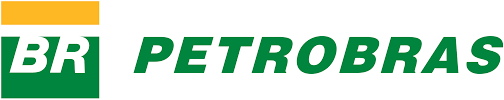

# ***PRECIO DE LA ACCIONES DE PETROBRAS***
Petrobras, oficialmente conocida como Petróleo Brasileiro S.A., es una empresa energética brasileña de gran importancia a nivel nacional e internacional. Sus acciones abarcan una amplia gama de actividades en el sector de la energía, incluyendo exploración, producción, refinación, distribución y comercialización de petróleo y gas natural, así como también en la generación de energía eléctrica y otras áreas relacionadas.

A continuación presentamos T=624 observaciones que constan de los retornos de precios diarios de las acciones de Petrobras medidos hasta 23 de abril de 2024.  


# Librerías y Carga de los Datos


In [ ]:
# NOTA : Se recomienda ejecutar la rutina en R-Studio, ya que Colab presenta algunos #
# problemas de compatibilidad entre algunas librerías #

In [ ]:
# Primero se debe ejecutar este comando con entorno de Python para conectar con Drive #
# posteriormente cambiar el entorno para R. #
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Instalar Librerías #
# Se sugiere cargar previo a la presentación, es demorado en Colab #
install.packages("stats")
install.packages("astsa")
install.packages("forecast")
install.packages("tseries")
install.packages("nortest")
install.packages("fBasics")
install.packages("car")
install.packages("MLmetrics")
install.packages("matrixcalc")

In [ ]:
# Cargar Librerías #
library(stats)
library(astsa)
library(forecast)
library(tseries)
library(nortest)
library(fBasics)
library(car)
library(MLmetrics)
library(matrixcalc)

In [ ]:
# El paquete "googledrive" es una herramienta específica para interactuar con Google Drive desde R.
# Permite a los usuarios realizar una variedad de acciones relacionadas con Google Drive, como autenticarse
# en sus cuentas de Google, acceder a archivos y carpetas, cargar archivos en Google Drive y descargar archivos de Google Drive.
install.packages("googledrive")
library(googledrive)

In [ ]:
# Leer el archivo .txt desde mi Drive como un objeto ts() #
#rtn_ptbras <- ts(vec(t(as.matrix(read.table("/content/drive/MyDrive/Colab Notebooks/4_rtn_petrobras.txt", dec=".", sep="")))))
rtn_ptbras <- ts(vec(t(as.matrix(read.table("TU_RUTA/4_rtn_petrobras.txt", dec=".", sep="")))))

# Análisis Exploratorio

In [ ]:
# Gráfica de la Serie de Retornos Diarios de Petrobras #
plot.ts(rtn_ptbras, main = "Serie de Retornos Diarios de Petrobras", ylab="Retorno"); grid()

### La prueba de Dickey-Fuller es una prueba de raíz unitaria que se utiliza comúnmente para determinar si una serie de tiempo es estacionaria o no.                                                          
$H_0$ : No Estacionaria   $vs$    $H_a$ : Estacionaria

In [ ]:
# Aplicar la prueba de Dickey-Fuller de Estacionaridad #
adf.test(rtn_ptbras)

### Funciones de Autocorrelación y Autocorrelación Parcial

In [ ]:
# Gráfica de la ACF y PACF #
par(mfrow=c(2,1))
acf(rtn_ptbras, main="Función de Autocorrelación")
pacf(rtn_ptbras, main="Función de Autocorrelación Parcial", lag.max = 30)

In [ ]:
# Función de Autocorrelación Extendida. Se recomienda no instalar TSA al inicio por que trae incompatibildades con forecast()
#install.packages("TSA")
#library(TSA) #
eacf(rtn_ptbras, ar.max = 7, ma.max = 15)

In [ ]:
# Función que busca modelos según los criterios de información AIC Y BIC #
sarima.list = function(datos, p, d = 0, q, P = 0, D = 0, Q = 0, S = NA, include.mean = F, criterio = ""){
  M <- matrix(ncol = 10,nrow = (p+1)*(q+1)*(P+1)*(Q+1),dimnames=list(NULL,c("p","d","q","P","D","Q","S","converge","AIC", "BIC")))
  k <- 1
  n <- length(datos)
  for(i in 0:p){
    for(j in 0:q){
      for(l in 0:P){
        for(m in 0:Q){
          if ((i==0)&&(j==0)&&(l==0)&&(m==0)) next #Continua con la siguiente iteracion
          fit <- arima(datos, order = c(i, d, j),seasonal = list(order = c(l, D, m), period = S), include.mean = include.mean)
          M[k,1]  <- i
          M[k,2]  <- d
          M[k,3]  <- j
          M[k,4]  <- l
          M[k,5]  <- D
          M[k,6]  <- m
          M[k,7]  <- S
          M[k,8]  <- fit$code  # 0: Convergencia, 1: No Convergencia
          M[k,9]  <- AIC(fit)  # AIC
          M[k,10] <- AIC(fit, k = log(length(datos)))  # BIC
          k <- k+1
        }
      }
    }
  }
  if(criterio == "AIC"){
    M <- M[order(M[,9]),]
  }
  if(criterio == "BIC"){
    M <- M[order(M[,10]),]
  }
  if(criterio == ""){
    M <- M
  }
  rownames(M) = rep("", (p+1)*(q+1)*(P+1)*(Q+1))
  return(M[1:((p+1)*(q+1)*(P+1)*(Q+1)-1),])
}

In [ ]:
# Aplicar función que arroja los criterios de información #
select_model = data.frame(sarima.list(rtn_ptbras, p=3, d = 0, q=3, P = 0, D = 0, Q = 0, S = NA, include.mean = F, criterio = ""))

In [ ]:
# Ordenar por AIC #
(aic_order <- select_model[order(select_model$AIC), ])

In [ ]:
# Ordenar por BIC #
(bic_order <- select_model[order(select_model$BIC), ])

# Estimación de parámetros para un ARIMA(2,0,2)

In [ ]:
# Estimacion ML exacta con valores iniciales dados por la estimacion de Suma de Cuadrados Condicionales library(forecast) #
(mod_1 = arima(rtn_ptbras, c(2, 0, 2), method = c("CSS-ML")))
res_1 = residuals(mod_1)

In [ ]:
# Usando la función SARIMA() library(astsa) #
(mod_2 = sarima(rtn_ptbras, p=2, d=0, q=2))
mod_2$ttable # Para establecer la significancia de las estimativas
res_2 = mod_2$fit$residuals

# Diagnóstico Residual para el modelo ARIMA(2,0,2)

In [ ]:
# MODELO 1 arima() #
# Pruebas de Dianóstico - Análisis de Residuales arima() #
par(mfrow=c(3,2))
plot.ts(res_1, main="Residuales", ylab="")
hist(res_1, main="Histograma de Residuales")
acf(res_1, lag.max=25, main="ACF de Residuales")
pacf(res_1, lag.max=25, main="PACF de Residuales")

# Prueba de LJUNG-BOX para Independencia de los Residuales #
Box.Test = function(x, lag = 25, main = "p values for Ljung-Box statistic"){
  B<-vector("numeric")
  for(i in 1:lag){
    B[i]<-Box.test(x, lag = i, type = "Ljung-Box")$p.value
  }
  A<-matrix(cbind(c(1:lag),B), nrow = lag, ncol = 2, byrow=F, dimnames = list(NULL, c("lag", "p.value")))
  plot(A[,1], A[,2], ylim = c(0, max(0.051,(max(A[,2])+.01))),
       ylab = "p-value", xlab = "Lag", main = main, lwd = 2)
  abline(0.05, 0, col = 4, lty = 2)
}
Box.Test(res_1)

# Gráfico del Q-Q Plot #
qqPlot(res_1, envelope = 0.95, main = "Q-Q Plot de Residuos con Intervalo") #library(car)

In [ ]:
# MODELO 2 SARIMA() #
# Pruebas de Dianóstico - Análisis de Residuales arima()#
par(mfrow=c(3,2))
plot.ts(res_2, main="Residuales", ylab="")
hist(res_2, main="Histograma de Residuales")
acf(res_2, lag.max=25, main="ACF de Residuales")
pacf(res_2, lag.max=25, main="PACF de Residuales")

# Prueba de LJUNG-BOX para Independencia de los Residuales #
Box.Test = function(x, lag = 25, main = "p values for Ljung-Box statistic"){
  B<-vector("numeric")
  for(i in 1:lag){
    B[i]<-Box.test(x, lag = i, type = "Ljung-Box")$p.value
  }
  A<-matrix(cbind(c(1:lag),B), nrow = lag, ncol = 2, byrow=F, dimnames = list(NULL, c("lag", "p.value")))
  plot(A[,1], A[,2], ylim = c(0, max(0.051,(max(A[,2])+.01))),
       ylab = "p-value", xlab = "Lag", main = main, lwd = 2)
  abline(0.05, 0, col = 4, lty = 2)
}
Box.Test(res_2)

# Gráfico del Q-Q Plot #
qqPlot(res_2, envelope = 0.95, main = "Q-Q Plot de Residuos con Intervalo") #library(car)

### Algunas metodologías para probar normalidad
Aquí podemos chequear los residuales del modelo 1 (arima) o modelo 2 (sarima), en particualar analizaremos para el modelo 1.

In [ ]:
# Shapiro Wilk: Prueba de Hipótesis para contrastar normalidad #
shapiro.test(res_1)

In [ ]:
# Kolmogorov-Smirnov: Prueba no paramétrica basada en Bondad Ajuste #
lillie.test(res_1)

In [ ]:
# Jarque Bera: Basado en la Asimetría y Curtosis de una Normal #
jarqueberaTest(res_1)

In [ ]:
# Gráfico del Q-Q Plot #
qqPlot(res_1, envelope = 0.95, main = "Q-Q Plot de Residuos con Intervalo") #library(car)

### Función alternativa para encontrar modelos preliminares

In [ ]:
# Función que busca automáticamente el mejor modelo : autoarima() #
mod_auto = auto.arima(rtn_ptbras)
mod_auto

In [ ]:
 # Diagnóstico Residual Autoarima #
res_auto<-auto.arima(rtn_ptbras)$residuals
par(mfrow = c(3,2))
ts.plot(res_auto)
shapiro.test(res_auto)
Box.test(res_auto, type = c("Box-Pierce", "Ljung-Box"))
Box.Test(res_auto)
acf(res_auto, main="ACF de Ventas")
pacf(res_auto, main="PACF de Ventas")

# Gráfico del Q-Q Plot #
qqPlot(res_auto, envelope = 0.95, main = "Q-Q Plot de Residuos con Intervalo")

# Histograma con densidad aproximada #
hist(res_auto, freq = FALSE, main="Distribución de los residuales")
dens <- density(res_auto)
lines(dens, col = "red", lwd = 2)

# Pronóstico
La función "forecast" toma como entrada un modelo ajustado a datos históricos y produce estimaciones para períodos futuros. Estas estimaciones pueden ser útiles en una variedad de contextos, como la planificación empresarial, la gestión de inventarios, el análisis financiero y la predicción de tendencias en datos económicos, climáticos, entre otros.

In [ ]:
# Modelo a ser empleado en el pronóstico (Modelo 1) #
mod_arma = arima(rtn_ptbras, c(2, 0, 2), method = c("CSS-ML"))
mod_arma

In [ ]:
# Podemos analizar las diferentes métricas para medir pronósticos, en particular el MAPE #
summary(mod_arma, )

In [ ]:
# Pronósticos para la serie de ventas con horizonte 30 (1 mes) #
fc_arma = forecast(rtn_ptbras, model = mod_arma, h = 30)
fc_arma

In [ ]:
# Gráfico de la series de ventas con sus respectivos pronósticos #
plot(fc_arma, ylab="Retornos Diarios", xlab="Día", main="Pronósticos de los Retornos Diarios")